# 🟠 Basic MNIST Diffuser

Take an MNIST image, add 10% noise, then train a network to recover the original.

Train for 10 epochs.

Then sample pure noise and throw it in.

Whatever comes out, throw it back in again.

Repeat 10x, and it'll "imagine" a fresh MNIST digit.

It's amazing to me that such a simple thing works so well.

This may be useful for measuring how much information gets stored in an FFF layer.

i.e. it may give some ideas

WARNING: It's an old notebook and I haven't tidied it up. π


In [1]:
! pip install -q torch torchvision matplotlib tqdm ipywidgets

In [2]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [3]:
# Load MNIST
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        './data', train=True, download=True, transform=transforms.ToTensor()
    ),
    batch_size=64, shuffle=True
)

## 🔸 Initial Experiment: Denoising Autoencoder

### Objective
The aim is to build a simplified model to understand the basic principles of denoising. In this model, we have a neural network that takes a noisy version of an image and attempts to reconstruct the original image.

### Model Architecture

The model consists of two fully connected layers:
1. Input Layer: 784 nodes (flattened 28x28 MNIST image)
2. Hidden Layer: 400 nodes
3. Output Layer: 784 nodes

The activation functions used are ReLU for the hidden layer and Sigmoid for the output layer.

```python
class ReverseProcess(nn.Module):
    def __init__(self):
        super(ReverseProcess, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 784)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))
```

### Training

We train the model using Mean Squared Error (MSE) loss, given by the equation:

$$ \text{MSE Loss} = \frac{1}{N} \sum_{i=1}^{N} (x_i - \hat{x}_i)^2 $$

Here $ x_i $ is the original data and $ \hat{x}_i $ is the reconstructed data.

### Results

The model successfully denoises the input images, providing a good starting point for more complex models.

In [4]:
from IPython.display import display, HTML, clear_output

display(HTML("""
<style>
.cell-output-ipywidget-background {
    background-color: gray !important;
}
</style>
"""))

In [5]:
# Model Definition
class ReverseProcess(nn.Module):
    def __init__(self):
        super(ReverseProcess, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 784)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

# Initialize model and optimizer
model = ReverseProcess()
optimizer = optim.Adam(model.parameters(), lr=0.001)

NEPOCH = 8

# Loop over epochs without tqdm
for epoch in range(NEPOCH):
    epoch_loss = 0.0
    num_batches = 0

    # Initialize tqdm for batches within each epoch
    batch_tqdm = tqdm(enumerate(train_loader), total=len(train_loader), leave=False, desc=f'Epoch {epoch}')

    for batch_idx, (data, _) in batch_tqdm:
        data = data.view(-1, 784)
        noisy_data = data + torch.randn_like(data) * 0.1
        output = model(noisy_data)
        
        loss = nn.MSELoss()(output, data)
        epoch_loss += loss.item()
        num_batches += 1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_tqdm.set_postfix({'Batch Loss': f'{loss.item():.5f}'})

    clear_output(wait=True)

    avg_loss = epoch_loss / num_batches
    print(f'Epoch {epoch} / {NEPOCH} Completed: Avg Loss {avg_loss:.5f}')


Epoch 7 / 8 Completed: Avg Loss 0.00198


In [17]:
# def plot(model, data_loader, num_iterations=10, latent_dim=784, num_samples=10):
#     def plot_row(axes_row, images, title, cmap='gray'):
#         for i, ax in enumerate(axes_row):
#             ax.imshow(images[i].reshape(28, 28), cmap=cmap)
#             ax.axis('off')
#             ax.set_title(f'{title} {i+1}')

#     fig, axes = plt.subplots(3 + num_iterations, num_samples, figsize=(20, 8))

#     # Generate latent samples
#     latent_samples = torch.randn(num_samples, latent_dim)
#     with torch.no_grad():
#         for i in range(num_iterations):
#             plot_row(axes[3 + i], latent_samples, 'Generated')
#             latent_samples = model(latent_samples)


#     # Generate reconstructed samples
#     data, _ = next(iter(data_loader))
#     data = data.view(-1, 784)
#     noisy_data = data + torch.randn_like(data) * 0.1
#     with torch.no_grad():
#         reconstructed_data = model(noisy_data).view(-1, 28, 28)

#     plot_row(axes[0], data, 'Original')
#     plot_row(axes[1], noisy_data, 'Noisy')
#     plot_row(axes[2], reconstructed_data, 'Reconstructed')
#     # plot_row(axes[3], latent_samples, 'Generated')

#     plt.show()

import matplotlib.pyplot as plt
import torch

def plot(model, data_loader, num_iterations=10, latent_dim=784, num_samples=10):
    def plot_row(axes_row, images, title, cmap='gray'):
        for i, ax in enumerate(axes_row):
            ax.imshow(images[i].reshape(28, 28), cmap=cmap)
            ax.axis('off')
            ax.set_title(f'{title} {i+1}', fontsize=8)  # Reduce font size

    # Adjust figsize
    fig, axes = plt.subplots(3 + num_iterations, num_samples, figsize=(10, num_iterations + 3))

    # Generate latent samples
    latent_samples = torch.randn(num_samples, latent_dim)
    with torch.no_grad():
        for i in range(num_iterations):
            plot_row(axes[3 + i], latent_samples, 'Generated')
            latent_samples = model(latent_samples)

    # Generate reconstructed samples
    data, _ = next(iter(data_loader))
    data = data.view(-1, 784)
    noisy_data = data + torch.randn_like(data) * 0.1
    with torch.no_grad():
        reconstructed_data = model(noisy_data).view(-1, 28, 28)

    plot_row(axes[0], data, 'Original')
    plot_row(axes[1], noisy_data, 'Noisy')
    plot_row(axes[2], reconstructed_data, 'Reconstructed')

    plt.subplots_adjust(wspace=0.2, hspace=0.3)  # Adjust the spacing between subplots
    plt.show()

TypeError: TimeAwareVAE.forward() missing 1 required positional argument: 'time_step'

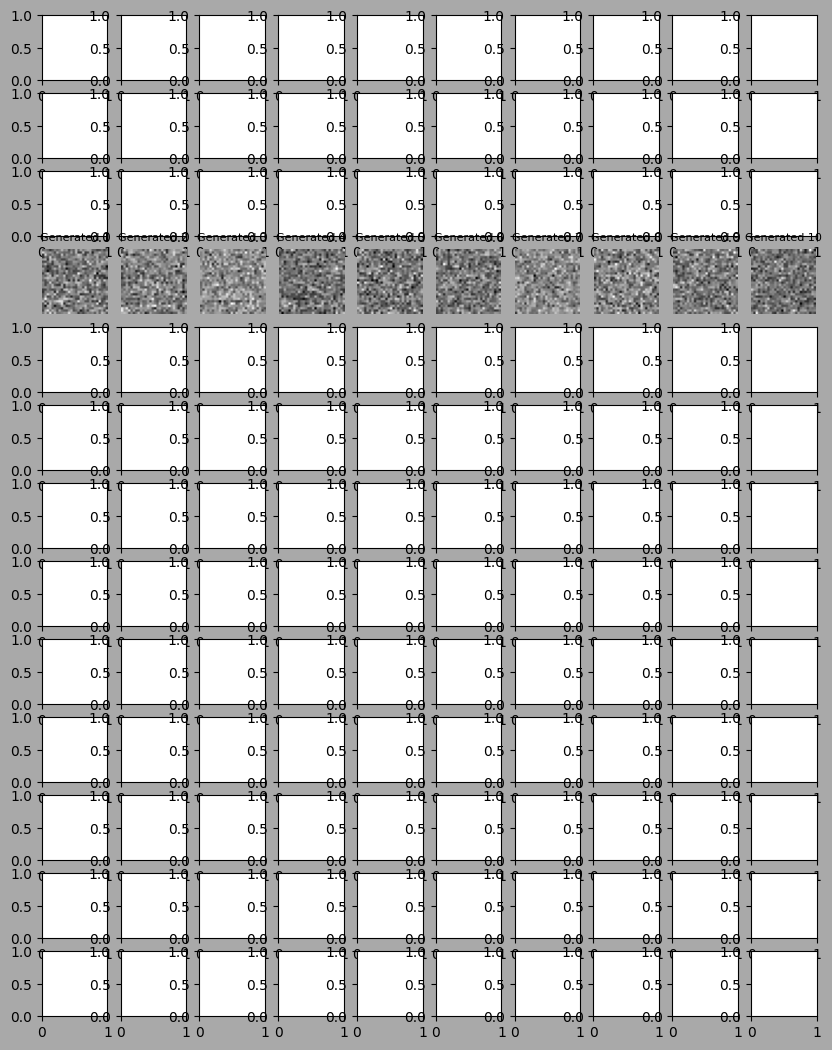

In [18]:
# Usage
plot(model, data_loader=train_loader)


## 🔸 Chapter 2: Exploration and Enhancement

### Objective

The first model was a foundational exercise. Now, we aim to explore additional techniques to improve the model's effectiveness and also to generate new samples.

### Advanced Techniques

#### 1. Introduce More Layers

Increasing the complexity of the model can result in better denoising and generation capabilities.

#### 2. Activation Functions

Experiment with other activation functions like LeakyReLU, Tanh, etc.

#### 3. Regularization Techniques

Consider adding dropout layers or L1/L2 regularization to reduce overfitting.

#### 4. Variational Bound

The first model used a simple MSE loss. Advanced models often use a variational bound on the negative log-likelihood as a more rigorous loss function.

$$ L(\theta, \phi; x) = -\mathbb{E}_{z \sim q_\phi(z|x)}[\log p_\theta(x|z)] + \text{KL}(q_\phi(z|x) || p(z)) $$

### Generation of New Samples

One of the interesting aspects to explore is the model's capability to generate new samples. By feeding random noise as input, we can observe how well the model generates new samples that resemble the original data distribution.

### Code Snippets

For new layers and activation functions, you can modify the model class definition. For regularization, you can introduce dropout layers or add a regularization term in your loss function. For sample generation, you can use a random noise input and pass it through the trained model.

### What To Expect?

- Improved denoising capabilities
- More robustness to different kinds of noise
- A model that can generate new, but plausible, samples


In [19]:
# Enhanced Model Definition
class EnhancedReverseProcess(nn.Module):
    def __init__(self):
        super(EnhancedReverseProcess, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 256)
        self.fc5 = nn.Linear(256, 512)
        self.fc6 = nn.Linear(512, 784)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        return torch.sigmoid(self.fc6(x))

# Initialize model and optimizer
model = EnhancedReverseProcess()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [20]:
NEPOCH = 5

# Initialize tqdm for epochs
for epoch in range(NEPOCH):
    epoch_loss = 0.0
    num_batches = 0

    # Initialize tqdm for batches within each epoch
    batch_tqdm = tqdm(enumerate(train_loader), total=len(train_loader), leave=False, desc=f'Epoch {epoch}')

    for batch_idx, (data, _) in batch_tqdm:
        data = data.view(-1, 784)
        noisy_data = data + torch.randn_like(data) * 0.1  # Add noise
        output = model(noisy_data)  # Get model output
        
        loss = nn.MSELoss()(output, data)  # Compute loss
        epoch_loss += loss.item()
        num_batches += 1

        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights

        batch_tqdm.set_postfix({'Batch Loss': f'{loss.item():.5f}'})

    clear_output(wait=True)

    avg_loss = epoch_loss / num_batches
    print(f'Epoch {epoch} / {NEPOCH} Completed: Avg Loss {avg_loss:.5f}')


Epoch 4 / 5 Completed: Avg Loss 0.01781


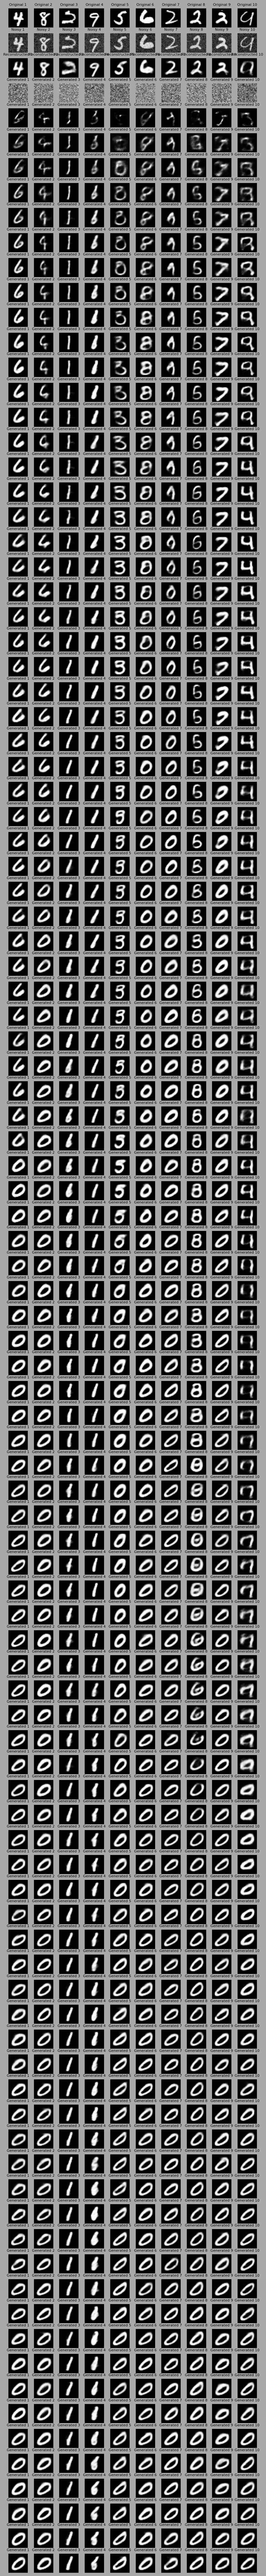

In [22]:
plot(model, data_loader=train_loader, num_iterations=100)


In [11]:
# Time-Aware Enhanced Model Definition
class TimeAwareEnhancedReverseProcess(nn.Module):
    def __init__(self):
        super(TimeAwareEnhancedReverseProcess, self).__init__()
        self.fc1 = nn.Linear(785, 512)  # 784 for image + 1 for time step
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 256)
        self.fc5 = nn.Linear(256, 512)
        self.fc6 = nn.Linear(512, 784)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x, time_step):
        time_step = time_step.expand(x.shape[0], 1)
        x = torch.cat([x, time_step], dim=1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        return torch.sigmoid(self.fc6(x))

# Initialize model and optimizer
model = TimeAwareEnhancedReverseProcess()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [12]:
# Refactored code to remove individual deltas
# Assuming other setup code and imports are already present

# Epoch and Iteration settings
NEPOCH = 5
num_iterations = 10
noise_schedule = torch.linspace(0.1, 0.5, num_iterations)

# Main Training Loop
for epoch in range(NEPOCH):
    epoch_loss = 0.0
    num_batches = 0

    batch_tqdm = tqdm(enumerate(train_loader), total=len(train_loader), leave=False, desc=f'Epoch {epoch}')
    
    for batch_idx, (data, _) in batch_tqdm:
        data = data.view(-1, 784)
        recon_data = data.clone()

        time_loss = 0.0  # Initialize time-dependent loss

        # Forward and reverse diffusion processes with loss at each time step
        for t in range(num_iterations):
            noise = torch.randn_like(recon_data) * noise_schedule[t]
            recon_data = recon_data + noise

            time_tensor = torch.tensor([t / num_iterations], dtype=torch.float32)
            recon_data = model(recon_data, time_tensor)

            # Compute time-dependent loss and average over time steps
            time_loss += nn.MSELoss()(recon_data, data) / num_iterations

        epoch_loss += time_loss.item()
        num_batches += 1

        optimizer.zero_grad()
        time_loss.backward()
        optimizer.step()

        batch_tqdm.set_postfix({'Batch Loss': f'{time_loss.item():.5f}'})

    avg_loss = epoch_loss / num_batches
    print(f'Epoch {epoch} / {NEPOCH} Completed: Avg Loss {avg_loss:.5f}')


Epoch 0:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 0 / 5 Completed: Avg Loss 0.06539


Epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1 / 5 Completed: Avg Loss 0.06128


Epoch 2:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2 / 5 Completed: Avg Loss 0.05923


Epoch 3:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3 / 5 Completed: Avg Loss 0.05834


Epoch 4:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4 / 5 Completed: Avg Loss 0.05629


In [13]:
def plot(model, data_loader, num_iterations=10, latent_dim=784, num_samples=10):
    def plot_row(axes_row, images, title, cmap='gray'):
        for i, ax in enumerate(axes_row):
            ax.imshow(images[i].reshape(28, 28), cmap=cmap)
            ax.axis('off')
            ax.set_title(f'{title} {i+1}')

    fig, axes = plt.subplots(num_iterations + 3, num_samples, figsize=(30, 15))

    # Generate reconstructed samples
    data, _ = next(iter(data_loader))
    data = data.view(-1, 784)
    noisy_data = data + torch.randn_like(data) * 0.1
    reconstructed_data = noisy_data.clone()

    plot_row(axes[0], data, 'Original')
    plot_row(axes[1], noisy_data, 'Noisy')

    with torch.no_grad():
        for t in reversed(range(num_iterations)):
            time_tensor = torch.tensor([t / num_iterations], dtype=torch.float32)
            reconstructed_data = model(reconstructed_data, time_tensor)
        
    plot_row(axes[2], reconstructed_data, 'Reconstructed')

    # Generate latent samples
    latent_samples = torch.randn(num_samples, latent_dim)
    with torch.no_grad():
        for t in range(num_iterations):
            time_tensor = torch.tensor([t / num_iterations], dtype=torch.float32)
            latent_samples = model(latent_samples, time_tensor)
            plot_row(axes[3+t], latent_samples, f'Generated T={t}')

    plt.show()


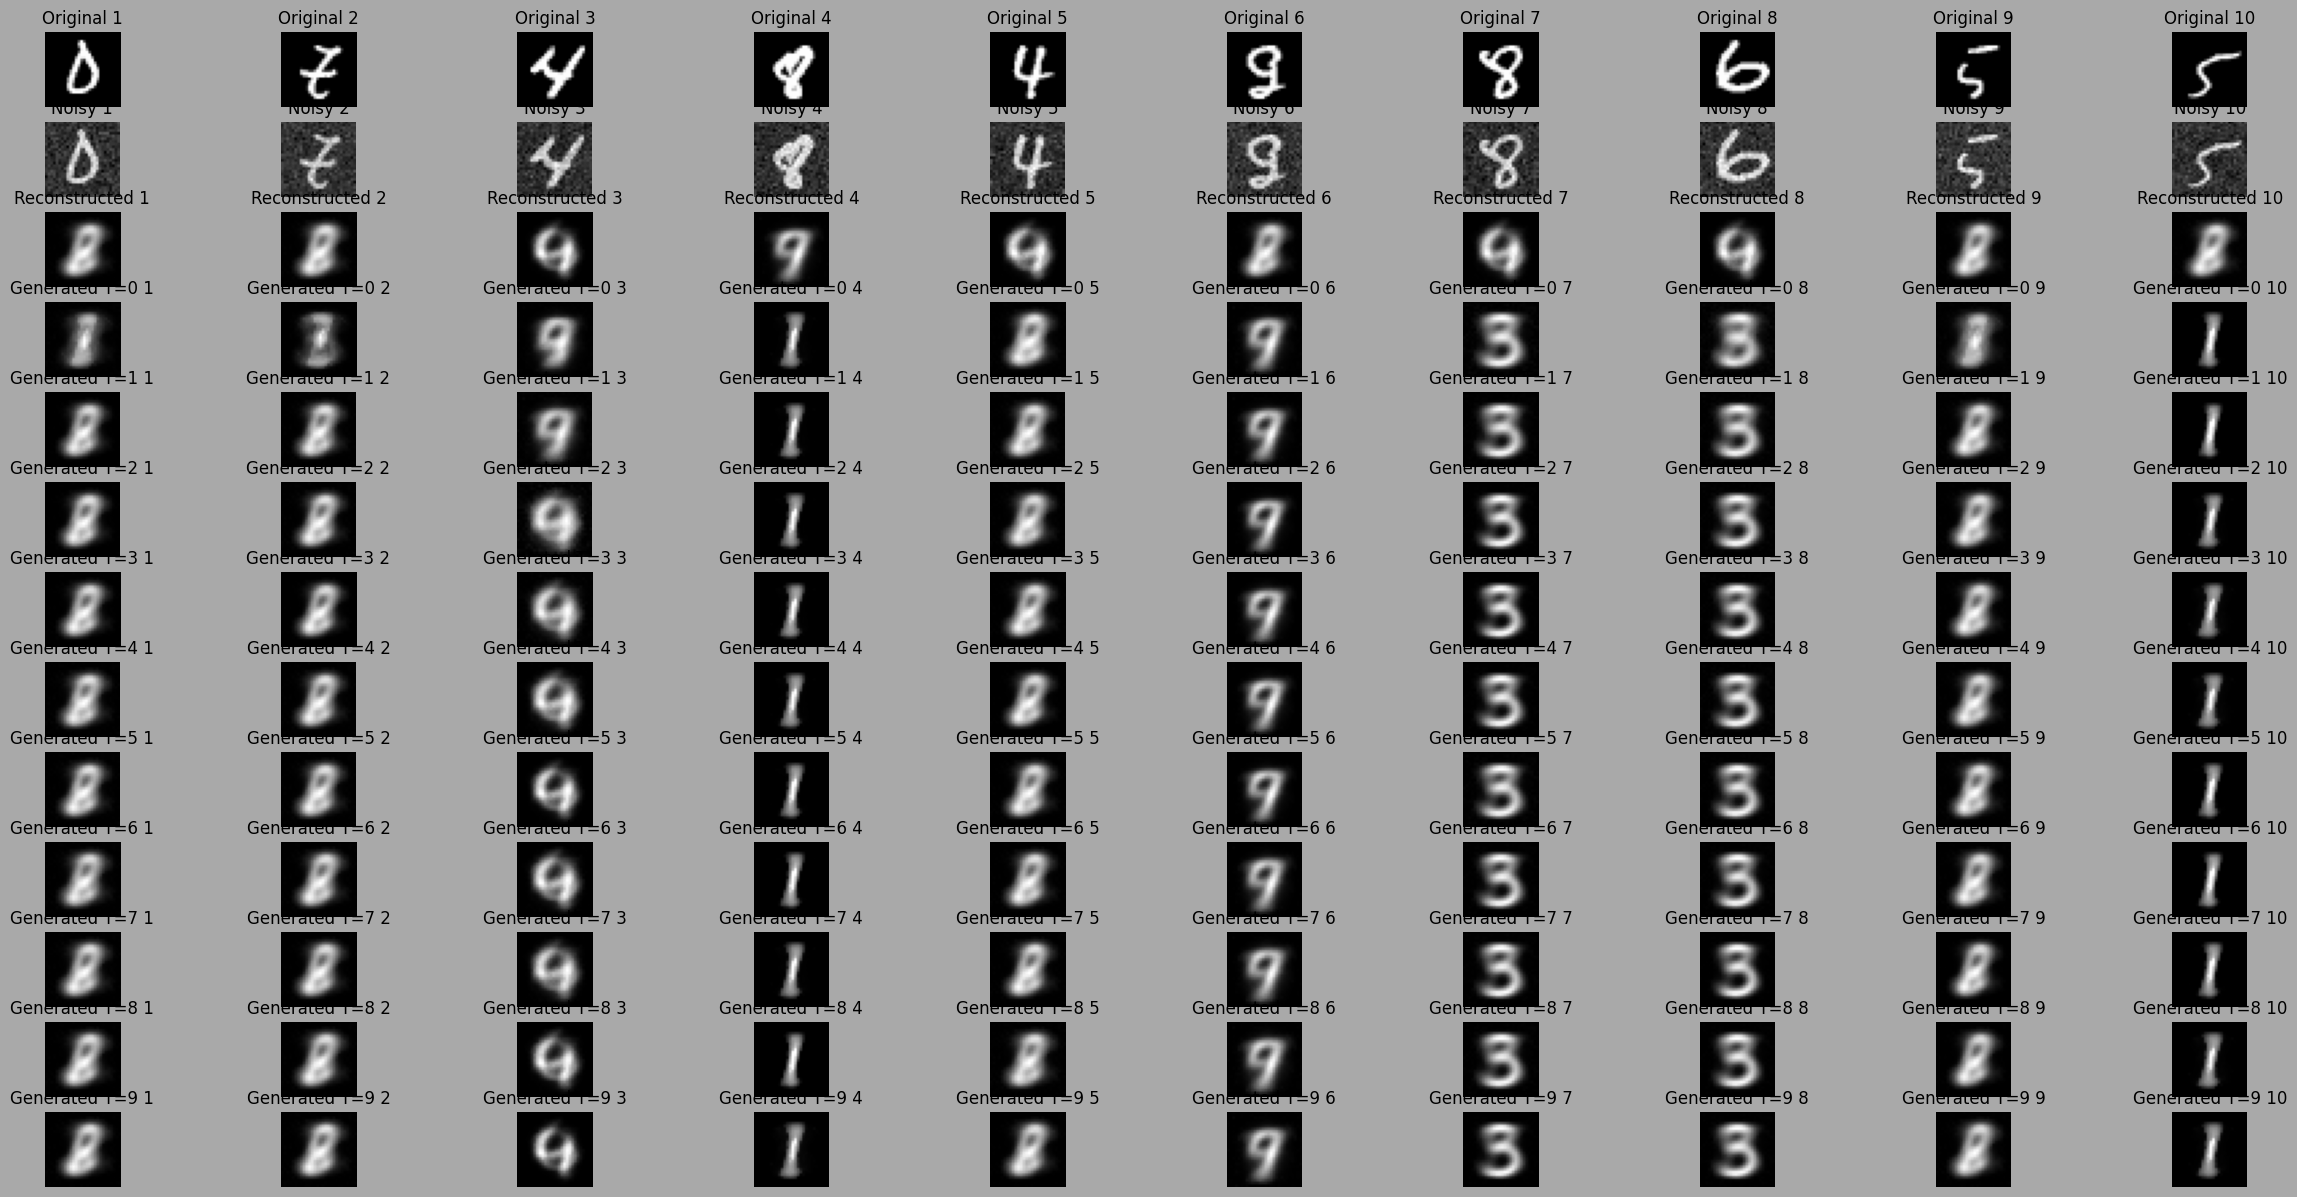

In [14]:
plt.rcParams['figure.facecolor'] = 'darkgray'

plot(model, data_loader=train_loader)


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

# VAE Model with Time Awareness
class TimeAwareVAE(nn.Module):
    def __init__(self, latent_dim=50):
        super(TimeAwareVAE, self).__init__()
        # Encoder
        self.enc1 = nn.Linear(785, 512)
        self.enc2 = nn.Linear(512, 256)
        self.enc3 = nn.Linear(256, latent_dim * 2)  # We need mean and log var
        
        # Decoder
        self.dec1 = nn.Linear(latent_dim + 1, 256)
        self.dec2 = nn.Linear(256, 512)
        self.dec3 = nn.Linear(512, 784)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, time_step):
        time_step = time_step.expand(x.shape[0], 1)
        x = torch.cat([x, time_step], dim=1)
        x = torch.relu(self.enc1(x))
        x = torch.relu(self.enc2(x))
        x = self.enc3(x).view(-1, 2, 50)
        
        mu = x[:, 0, :]
        logvar = x[:, 1, :]

        z = self.reparameterize(mu, logvar)
        z = torch.cat([z, time_step], dim=1)
        
        x = torch.relu(self.dec1(z))
        x = torch.relu(self.dec2(x))
        return torch.sigmoid(self.dec3(x)), mu, logvar

    def decode(self, z, time_step):
        time_step = time_step.expand(z.shape[0], 1)
        z = torch.cat([z, time_step], dim=1)
        
        x = torch.relu(self.dec1(z))
        x = torch.relu(self.dec2(x))
        # return torch.sigmoid(self.dec3(x))
        return self.dec3(x), mu, logvar

# Initialize model and optimizer
latent_dim = 50
model = TimeAwareVAE(latent_dim=latent_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Data Loader
# Assuming you've set up the DataLoader `train_loader` already.

# Training Settings
NEPOCH = 5

# Main Training Loop
for epoch in range(NEPOCH):
    epoch_loss = 0.0
    num_batches = 0
    for batch_idx, (data, _) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data = data.view(-1, 784)
        time_tensor = torch.tensor([batch_idx / len(train_loader)], dtype=torch.float32)

        recon_data, mu, logvar = model(data, time_tensor)

        # Compute ELBO
        recon_loss = nn.BCEWithLogitsLoss()(recon_data, data)
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        elbo = recon_loss + kl_div

        optimizer.zero_grad()
        elbo.backward()
        optimizer.step()

        epoch_loss += elbo.item()
        num_batches += 1

    avg_loss = epoch_loss / num_batches
    print(f'Epoch {epoch} / {NEPOCH} Completed: Avg Loss {avg_loss:.5f}')


100%|██████████| 938/938 [00:05<00:00, 167.73it/s]


Epoch 0 / 5 Completed: Avg Loss 0.71548


100%|██████████| 938/938 [00:05<00:00, 176.97it/s]


Epoch 1 / 5 Completed: Avg Loss 0.69330


100%|██████████| 938/938 [00:05<00:00, 170.35it/s]


Epoch 2 / 5 Completed: Avg Loss 0.69318


100%|██████████| 938/938 [00:05<00:00, 176.89it/s]


Epoch 3 / 5 Completed: Avg Loss 0.69317


100%|██████████| 938/938 [00:05<00:00, 174.96it/s]

Epoch 4 / 5 Completed: Avg Loss 0.69315


AttributeError: 'tuple' object has no attribute 'shape'

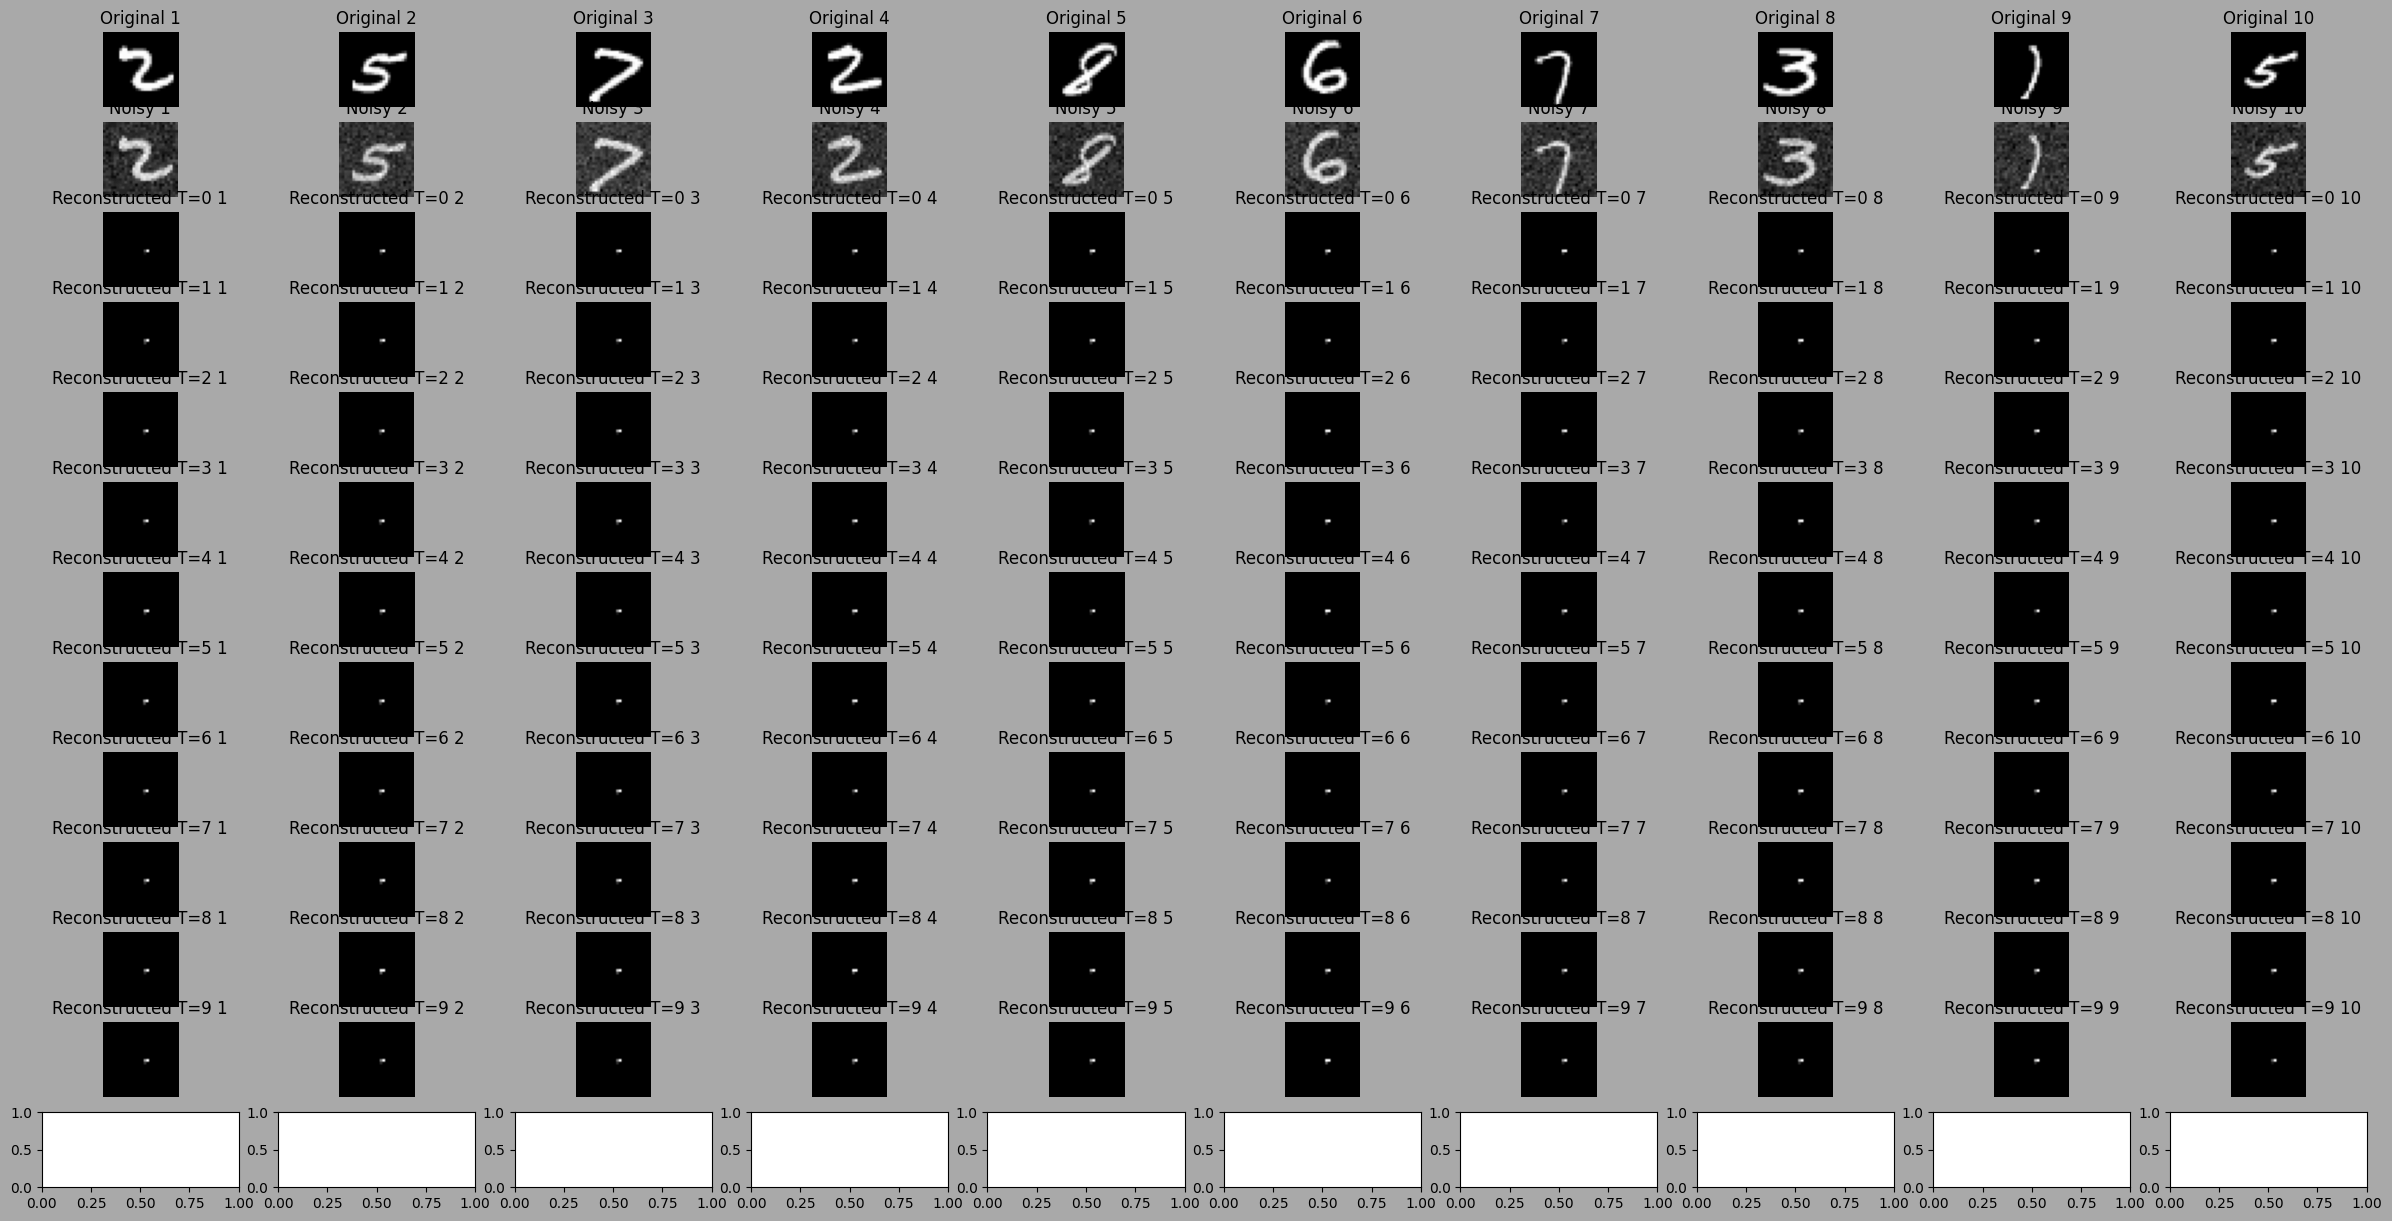

In [16]:
def plot(model, data_loader, num_iterations=10, latent_dim=50, num_samples=10):
    def plot_row(axes_row, images, title, cmap='gray'):
        for i, ax in enumerate(axes_row):
            ax.imshow(images[i].reshape(28, 28), cmap=cmap)
            ax.axis('off')
            ax.set_title(f'{title} {i+1}')

    fig, axes = plt.subplots(num_iterations + 3, num_samples, figsize=(30, 15))

    # Generate reconstructed samples
    data, _ = next(iter(data_loader))
    data = data.view(-1, 784)
    noisy_data = data + torch.randn_like(data) * 0.1
    plot_row(axes[0], data, 'Original')
    plot_row(axes[1], noisy_data, 'Noisy')

    with torch.no_grad():
        for t in reversed(range(num_iterations)):
            time_tensor = torch.tensor([t / num_iterations], dtype=torch.float32)
            reconstructed_data, _, _ = model(noisy_data, time_tensor)
            plot_row(axes[2 + t], reconstructed_data, f'Reconstructed T={t}')

        # Generate latent samples
        latent_samples = torch.randn(num_samples, latent_dim)
        with torch.no_grad():
            for t in range(num_iterations):
                time_tensor = torch.tensor([t / num_iterations], dtype=torch.float32)
                
                # Map the latent samples back to the data space (Assuming you have a method `decode` in your VAE model)
                # decoded_samples = model.decode(latent_samples)
                decoded_samples = model.decode(latent_samples, time_tensor)

                # Now apply the forward model
                generated_data, _, _ = model(decoded_samples, time_tensor)
                
                plot_row(axes[2 + t], generated_data, f'Generated T={t}')

    plt.show()

plot(model, data_loader=train_loader)
